In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import keras
import tensorflow

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, precision_score, f1_score

from sklearn.model_selection import train_test_split

In [ ]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 6.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
tf.random.set_seed(42)
print(tf.__version__)

2.14.0


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import numpy as np
np.random.seed(42)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
dir = "/content/drive/MyDrive/Colab Notebooks/ASD/Dataset/"

tk_categories = ['Autistic','Non_Autistic']

data = []
for c in tk_categories:
  folder = os.path.join(dir,c)
  label = tk_categories.index(c)
  print(folder)
  print(label)
  for img in os.listdir(folder):
    image = os.path.join(folder,img)
    img_arr = cv2.imread(image)
    img_arr = cv2.resize(img_arr,(72,72))
    data.append([img_arr,label])

x = []
y = []
for feature,label in data:
  x.append(feature)
  y.append(label)

x = np.array(x)
y = np.array(y)

x_train,x_test, y_train,y_test = train_test_split(x,y,test_size=0.30)

/content/drive/MyDrive/Colab Notebooks/ASD/Dataset/Autistic
0
/content/drive/MyDrive/Colab Notebooks/ASD/Dataset/Non_Autistic
1


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100
image_size = 72  # Final Image Size
patch_size = 6  # Patch Dimension
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def multilayer_perceptron(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


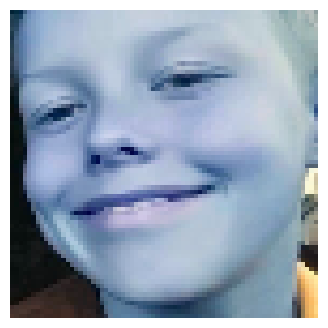

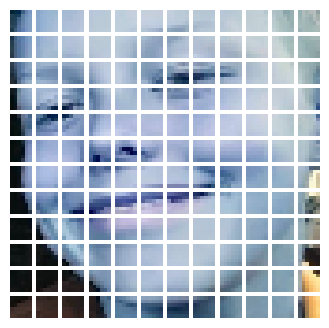

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input((72,72,3))

    augmented = data_augmentation(inputs)

    patches = Patches(patch_size)(augmented)

    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)


    for _ in range(transformer_layers):

        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])

        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        x3 = multilayer_perceptron(x3, hidden_units=transformer_units, dropout_rate=0.1)

        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    features = multilayer_perceptron(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    logits = layers.Dense(10)(features)

    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [ ]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/100
30/30 [==============================] - 37s 206ms/step - loss: 2.6735 - accuracy: 0.5546 - top-5-accuracy: 0.9817 - val_loss: 0.7675 - val_accuracy: 0.6244 - val_top-5-accuracy: 1.0000
Epoch 2/100
30/30 [==============================] - 4s 119ms/step - loss: 1.0265 - accuracy: 0.6240 - top-5-accuracy: 1.0000 - val_loss: 0.6799 - val_accuracy: 0.6244 - val_top-5-accuracy: 1.0000
Epoch 3/100
30/30 [==============================] - 4s 143ms/step - loss: 0.7125 - accuracy: 0.6392 - top-5-accuracy: 1.0000 - val_loss: 0.5870 - val_accuracy: 0.6854 - val_top-5-accuracy: 1.0000
Epoch 4/100
30/30 [==============================] - 4s 139ms/step - loss: 0.6602 - accuracy: 0.6721 - top-5-accuracy: 1.0000 - val_loss: 0.5753 - val_accuracy: 0.6901 - val_top-5-accuracy: 1.0000
Epoch 5/100
30/30 [==============================] - 3s 111ms/step - loss: 0.6256 - accuracy: 0.6804 - top-5-accuracy: 1.0000 - val_loss: 0.7110 - val_accuracy: 0.6103 - val_top-5-accuracy: 1.0000
Epoch 6/100
30

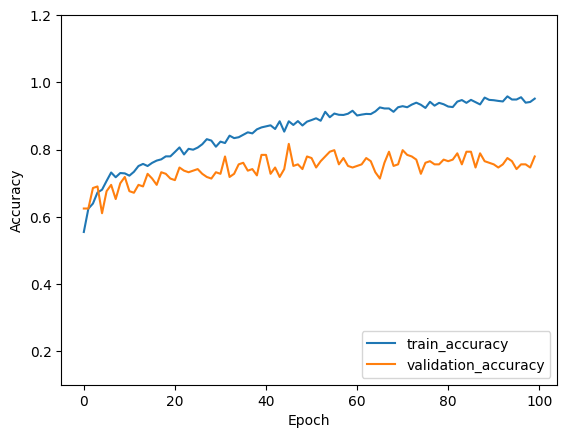

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1.2])
plt.legend(loc='lower right')

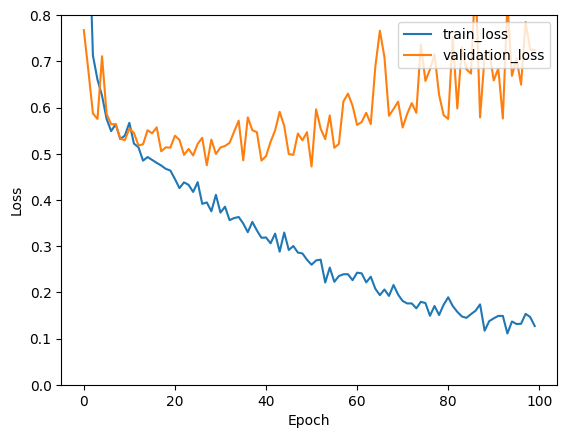

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.8])
plt.legend(loc='upper right')

29/29 [==============================] - 2s 23ms/step


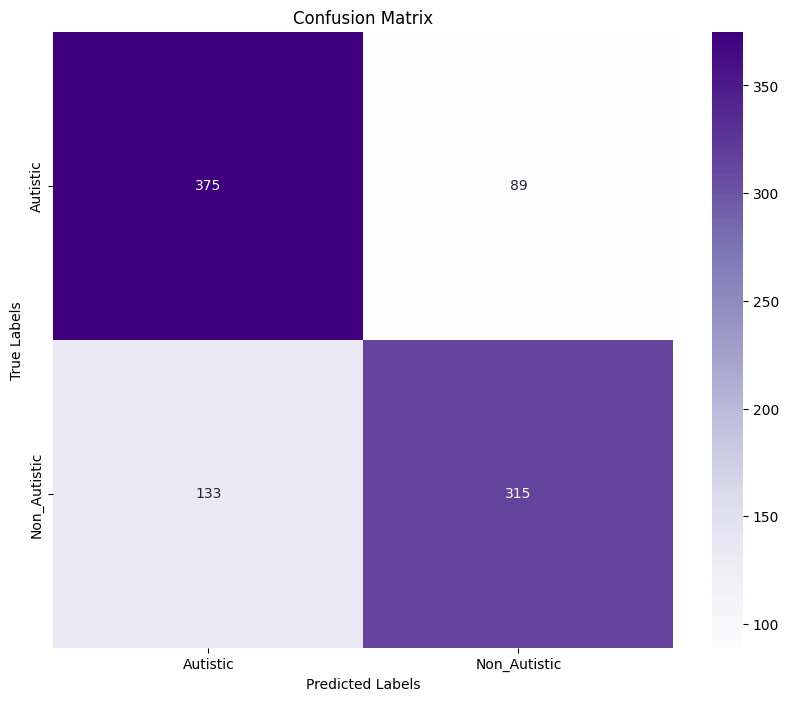

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = vit_classifier.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

def plot_confusion_matrix(confusion_mtx, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        confusion_mtx,
        annot=True,
        fmt="d",
        cmap="Purples",
        xticklabels=labels,
        yticklabels=labels,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Define your class labels (replace this with your actual class labels)
class_labels = ['Autistic','Non_Autistic']

# Plot the confusion matrix heatmap
plot_confusion_matrix(confusion_mtx, class_labels)

In [ ]:
from sklearn.metrics import classification_report

# After evaluating your model and calculating y_pred_classes
classification_rep = classification_report(y_test, y_pred_classes, target_names=class_labels)

# Print the classification report
print(classification_rep)

              precision    recall  f1-score   support

    Autistic       0.74      0.81      0.77       464
Non_Autistic       0.78      0.70      0.74       448

    accuracy                           0.76       912
   macro avg       0.76      0.76      0.76       912
weighted avg       0.76      0.76      0.76       912

